In [2]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import pickle
import numpy as np
import torch

In [3]:
with open("pose_labels/subject14_all_labels.cpl", "rb") as f:
    cpl = pickle.load(f)

cpl.keys()

dict_keys(['naive_gt_kps', 'refined_gt_kps', 'rgb_est_kps', 'radar_est_kps', 'imu_est_kps', 'rgb_avail_frames', 'radar_avail_frames', 'imu_avail_frames', 'gt_avail_frames', '2d_l_avail_frames', '2d_r_avail_frames', 'pose_2d_l', 'pose_2d_r', 'video_label', 'camera_matrix'])

In [4]:
def plot_3d_skeleton(keypoints, connections, skeleton_on=True, elev=0, azim=0):  
    # Create a 3D plot  
    fig = plt.figure(figsize=(10,10))  
    ax = fig.add_subplot(111, projection='3d')  
  
    # Plot keypoints  
    ax.scatter(keypoints[0], keypoints[1], keypoints[2], c='r', marker='o')  

    # Annotate keypoints with their indices  
    for i, (x, y, z) in enumerate(zip(keypoints[0], keypoints[1], keypoints[2]), start=0):  
        ax.text(x, y, z, f'{i}', color='black')
  
    # Plot connections  
    if skeleton_on:
        for connection in connections:  
            point1 = keypoints[:, connection[0]]  
            point2 = keypoints[:, connection[1]]  
            ax.plot(
                [point1[0], point2[0]], 
                [point1[1], point2[1]], 
                [point1[2], point2[2]], 
                'b-'
            )  
            
    
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(-3, 3)
  
    # Set labels  
    ax.set_xlabel('X')  
    ax.set_ylabel('Y')  
    ax.set_zlabel('Z')  
  
    # plt.gca().invert_xaxis()
    # plt.gca().invert_yaxis()
    # plt.gca().invert_zaxis()

    # Set the view angle  
    # elev = 0  # Elevation angle  
    # azim = 45  # Azimuthal angle  
    ax.view_init(elev=elev, azim=azim)
    # Show plot  
    plt.show()  

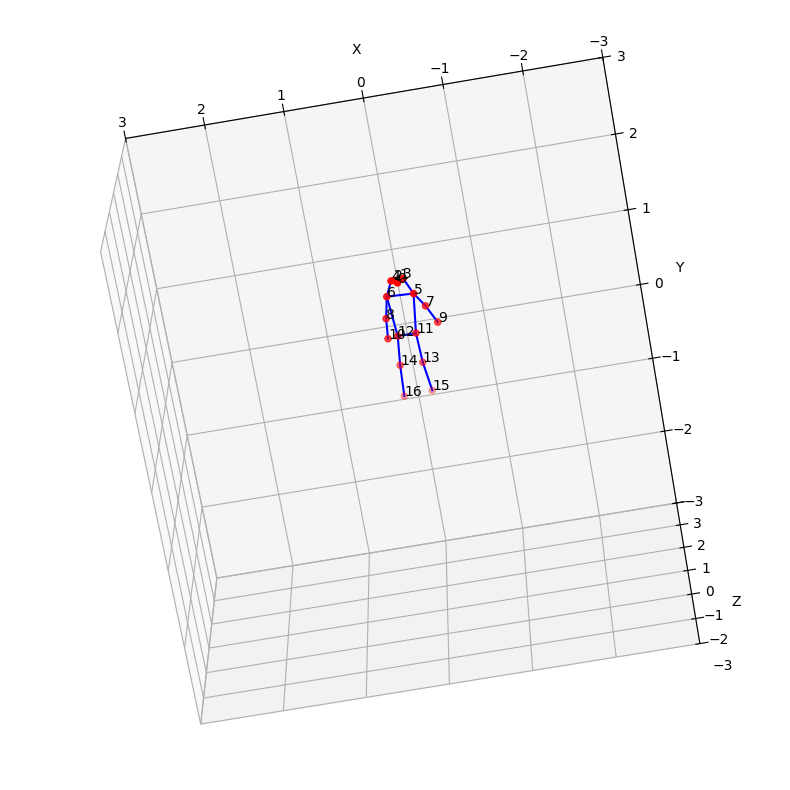

In [5]:
idx = 300
# keypoints = np.reshape(cpl['refined_gt_kps'][idx], (17, 3))  # Replace with your actual keypoints array  
keypoints = cpl['refined_gt_kps'][idx]
# Define connections between keypoints to form the skeleton  
connections = [
    (9,7), (7,5), (5,6), (6,8), (8,10),
    (5,3), (3,1), (1,0), (0,2), (2,4), (4,6),
    (5,11), (11,13), (13,15),
    (11,12),
    (6,12), (12,14), (14,16),
]
plot_3d_skeleton(keypoints, connections, skeleton_on=True, elev=290, azim=100)

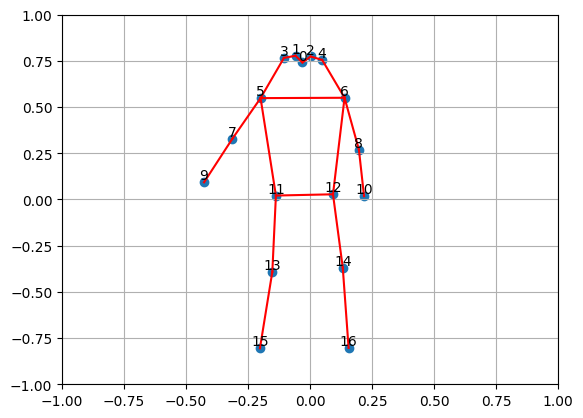

In [6]:
import numpy as np

pts = cpl['refined_gt_kps'][idx]
x_axis = 0
y_axis = 1

# Define the connections (pairs of indices)  
connections = [
    (9,7), (7,5), (5,6), (6,8), (8,10),
    (5,3), (3,1), (1,0), (0,2), (2,4), (4,6),
    (5,11), (11,13), (13,15),
    (11,12),
    (6,12), (12,14), (14,16),
]

fig, ax = plt.subplots()
# plt.gca().invert_yaxis()
ax.scatter(pts[x_axis], pts[y_axis])
for i, (x_coord, y_coord) in enumerate(zip(pts[x_axis], pts[y_axis]), start=0):
    plt.annotate(
        str(i), 
        (x_coord, y_coord), 
        textcoords="offset points", 
        xytext=(0, 2), 
        ha="center"
    )

# Plot the skeleton  
for connection in connections:  
    pt1 = pts[:, connection[0]]  
    pt2 = pts[:, connection[1]]  
    ax.plot([pt1[x_axis], pt2[x_axis]], [pt1[y_axis], pt2[y_axis]], 'r-')  
    
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.grid()
plt.show()


In [19]:
vid_filename = "blurred_videos/subject14_0505/subject14_color1.mp4"
frame_number = 200
import cv2
cap = cv2.VideoCapture(vid_filename)
amount_of_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print(amount_of_frames)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
res, frame = cap.read()
print(res)
frame.shape

6981.0
True


(1080, 1920, 3)

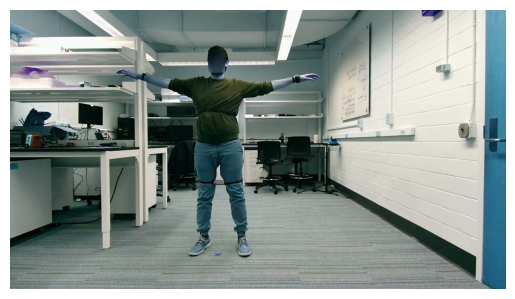

In [18]:
plt.imshow(frame)
plt.axis('off')
plt.show()


## Comparison

In [7]:
featuremap_validate = np.load('dataset_release/mri_radar_rede/data_tt.npy')  
labels_validate = np.load('dataset_release/mri_radar_rede/labels_tt.npy')  
featuremap_validate = torch.tensor(featuremap_validate, dtype=torch.float32)  
labels_validate = torch.tensor(labels_validate, dtype=torch.float32)  


In [8]:
print(featuremap_validate.shape, labels_validate.shape)

torch.Size([27170, 14, 14, 5]) torch.Size([27170, 51])


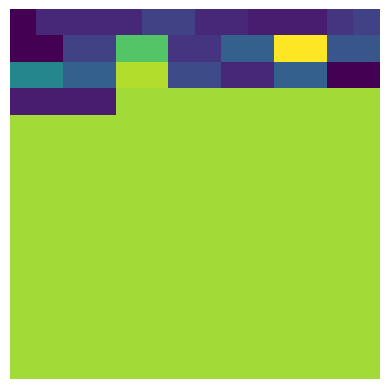

In [31]:
plt.imshow(featuremap_validate[100,:,:,4])
plt.axis('off')
plt.show()

In [9]:
n_keypoints = 51  


In [10]:
import torch.nn as nn  

class CNN(nn.Module):  
    def __init__(self, in_shape, n_keypoints):  
        super(CNN, self).__init__()  
        self.conv1 = nn.Conv2d(in_shape[0], 16, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  
        self.dropout = nn.Dropout(0.3)  
        self.batch_norm = nn.BatchNorm2d(32)  
        self.flatten = nn.Flatten()  
        self.fc1 = nn.Linear(32 * in_shape[1] * in_shape[2], 512)  
        self.fc2 = nn.Linear(512, n_keypoints)  
        self.fc_bn = nn.BatchNorm1d(512)  
        self.fc_dropout = nn.Dropout(0.4)  
  
    def forward(self, x):  
        x = torch.relu(self.conv1(x))  
        x = self.dropout(x)  
        x = torch.relu(self.conv2(x))  
        x = self.dropout(x)  
        x = self.batch_norm(x)  
        x = self.flatten(x)  
        x = torch.relu(self.fc1(x))  
        x = self.fc_bn(x)  
        x = self.fc_dropout(x)  
        x = self.fc2(x)  
        return x 

In [11]:
model = CNN(featuremap_validate[0].shape, n_keypoints)  
model = model.cuda() if torch.cuda.is_available() else model 
# Load the trained model weights (replace 'model.pth' with your actual model file)  
model.load_state_dict(torch.load('model_mri_pytorch/MARS.pth')) 

/tmp/ipykernel_26481/3313506913.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_mri_pytorch/MARS.pth'))


<All keys matched successfully>

In [12]:
# Set the model to evaluation mode  
model.eval()  
  
# Perform inference  
with torch.no_grad():  
    outputs = model(featuremap_validate.cuda())  
  
# Print the outputs  
print(outputs.shape)  

torch.Size([27170, 51])


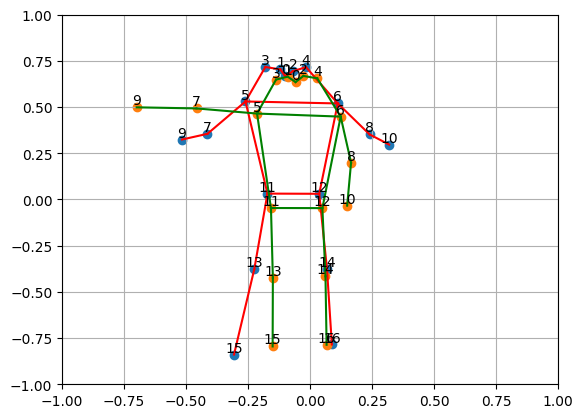

In [26]:
idx = 100

fig, ax = plt.subplots()

################ Plot prediction ################
pts = np.reshape(outputs[idx].cpu(), (3,17))
ax.scatter(pts[x_axis], pts[y_axis])
for i, (x_coord, y_coord) in enumerate(zip(pts[x_axis], pts[y_axis]), start=0):
    plt.annotate(
        str(i), 
        (x_coord, y_coord), 
        textcoords="offset points", 
        xytext=(0, 2), 
        ha="center"
    )

# Plot the skeleton  
for connection in connections:  
    pt1 = pts[:, connection[0]]  
    pt2 = pts[:, connection[1]]  
    ax.plot([pt1[x_axis], pt2[x_axis]], [pt1[y_axis], pt2[y_axis]], 'r-') 


################ Plot reference ################
pts = np.reshape(labels_validate[idx], (3,17))
ax.scatter(pts[x_axis], pts[y_axis])
for i, (x_coord, y_coord) in enumerate(zip(pts[x_axis], pts[y_axis]), start=0):
    plt.annotate(
        str(i), 
        (x_coord, y_coord), 
        textcoords="offset points", 
        xytext=(0, 2), 
        ha="center"
    )

# Plot the skeleton  
for connection in connections:  
    pt1 = pts[:, connection[0]]  
    pt2 = pts[:, connection[1]]  
    ax.plot([pt1[x_axis], pt2[x_axis]], [pt1[y_axis], pt2[y_axis]], 'g-')  
    
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.grid()
plt.show()